In [1]:
cd ..

/home/martinsevilla/langevin_ggm


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from ggm_estimation.format_results import compute_estimation_performance, plot_results

np.set_printoptions(suppress=True)

plt.rcParams['figure.figsize'] = [6, 5]

plt.rc('font', size=11)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize

mpl.rcParams['font.family'] = 'serif'
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

%load_ext autoreload
%autoreload 2

## Paper plots

Samples: 100


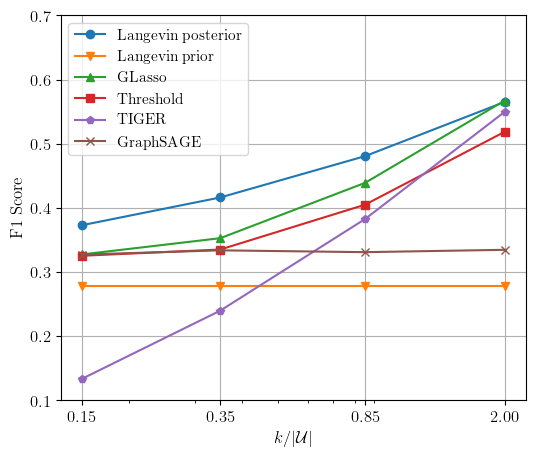

In [18]:
filename = "outputs/results_barabasi_0.1_True_0.2_10.csv"
tuneable_methods = ["langevin_posterior", "threshold", "gnn"]
fixed_methods = ["langevin_prior", "glasso", "tiger"]
train_size = 0.5
threshold_grid = {
    "langevin_posterior": np.linspace(0.45, 0.95, 5),
    "threshold": np.logspace(-1, 0, 5),
    "gnn": np.linspace(0.2, 0.8, 5),
}
metric = "f1"
col_x_axis = "obs_ratio"

np.random.seed(0)

scores = compute_estimation_performance(filename, tuneable_methods, fixed_methods, train_size, threshold_grid, metric, col_x_axis, n_splits=10)

labels = {
    "langevin_posterior": "Langevin posterior",
    "langevin_prior": "Langevin prior",
    "glasso": "GLasso",
    "threshold": "Threshold",
    "tiger": "TIGER",
    "gnn": "GraphSAGE",
}

# colors = {
#     "langevin_posterior": '#1f77b4',
#     "langevin_prior": "#2ca02c",
#     "glasso": "#d62728",
#     "threshold": "#9467bd",
#     "tiger": "#8c564b",
#     "gnn": "#e377c2",
# }

plot_results(scores, labels, 
            #  colors=colors, 
             ylabel="F1 Score", xlabel=r"$k / |\mathcal{U}|$", logscale=True,
             ylims=(0.1, 0.7),
             output_file="outputs/plots/barabasi.pdf")

Samples: 100


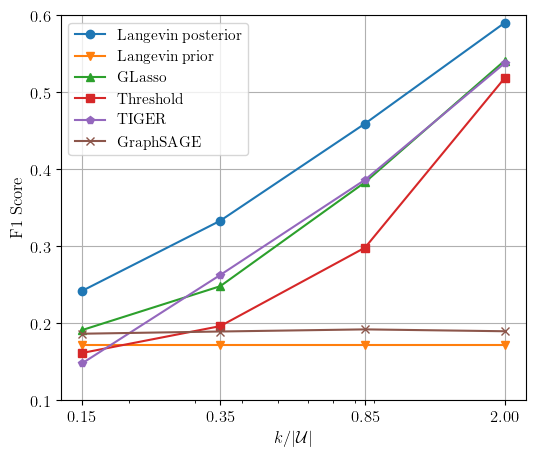

In [21]:
filename = "outputs/results_grids_0.2_True_None_10.csv"
tuneable_methods = ["langevin_posterior", "threshold", "gnn"]
fixed_methods = ["langevin_prior", "glasso", "tiger"]
train_size = 0.5
threshold_grid = {
    "langevin_posterior": np.linspace(0.45, 0.95, 5),
    "threshold": np.logspace(-1, 0, 5),
    "gnn": np.linspace(0.2, 0.8, 5),
}
metric = "f1"
col_x_axis = "obs_ratio"

np.random.seed(0)

scores = compute_estimation_performance(filename, tuneable_methods, fixed_methods, train_size, threshold_grid, metric, col_x_axis, n_splits=10)

labels = {
    "langevin_posterior": "Langevin posterior",
    "langevin_prior": "Langevin prior",
    "glasso": "GLasso",
    "threshold": "Threshold",
    "tiger": "TIGER",
    "gnn": "GraphSAGE",
}

# colors = {
#     "langevin_posterior": '#1f77b4',
#     "langevin_prior": "#2ca02c",
#     "glasso": "#d62728",
#     "threshold": "#9467bd",
#     "tiger": "#8c564b",
#     "gnn": "#e377c2",
# }

plot_results(scores, labels, 
            #  colors=colors, 
             ylabel="F1 Score", xlabel=r"$k / |\mathcal{U}|$", logscale=True,
             ylims=(0.1, 0.6),
             output_file="outputs/plots/grids_20.pdf")

Samples: 99


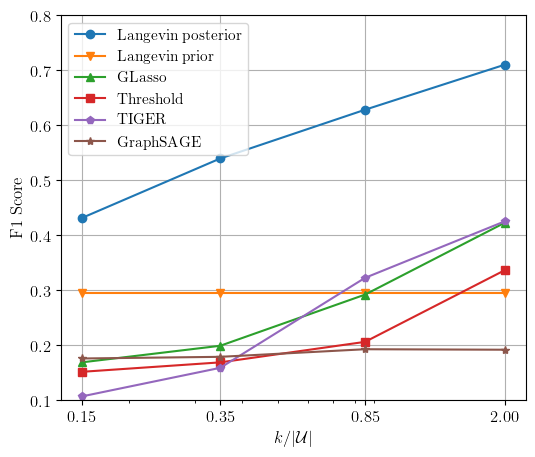

In [16]:
filename = "outputs/results_grids_0.1_True_None_10.csv"
tuneable_methods = ["langevin_posterior", "threshold", "gnn"]
fixed_methods = ["langevin_prior", "glasso", "tiger"]
train_size = 0.5
threshold_grid = {
    "langevin_posterior": np.linspace(0.45, 0.95, 5),
    "threshold": np.logspace(-1, 0, 5),
    "gnn": np.linspace(0.2, 0.8, 5),
}
metric = "f1"
col_x_axis = "obs_ratio"

np.random.seed(0)

scores = compute_estimation_performance(filename, tuneable_methods, fixed_methods, train_size, threshold_grid, metric, col_x_axis, n_splits=10)

labels = {
    "langevin_posterior": "Langevin posterior",
    "langevin_prior": "Langevin prior",
    "glasso": "GLasso",
    "threshold": "Threshold",
    "tiger": "TIGER",
    "gnn": "GraphSAGE",
}

# colors = {
#     "langevin_posterior": '#1f77b4',
#     "langevin_prior": "#2ca02c",
#     "glasso": "#d62728",
#     "threshold": "#9467bd",
#     "tiger": "#8c564b",
#     "gnn": "#e377c2",
# }

plot_results(scores, labels, 
            #  colors=colors, 
             ylabel="F1 Score", xlabel=r"$k / |\mathcal{U}|$", logscale=True,
             ylims=(0.05, 0.9),
             output_file="outputs/plots/grids_10.pdf")

Samples: 98


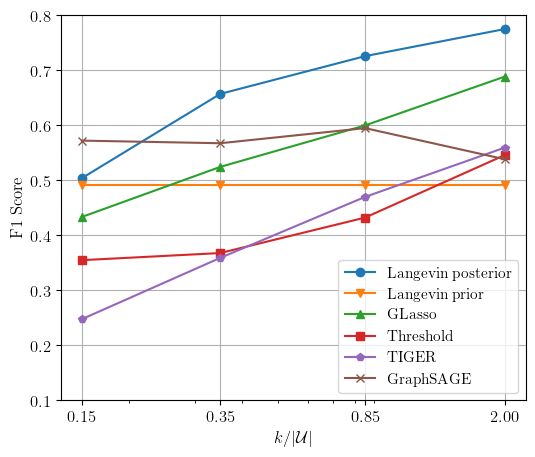

In [20]:
filename = "outputs/results_deezer_0.5_True_None_10.csv"
tuneable_methods = ["langevin_posterior", "threshold", "gnn"]
fixed_methods = ["langevin_prior", "glasso", "tiger"]
train_size = 0.5
threshold_grid = {
    "langevin_posterior": np.linspace(0.45, 0.95, 5),
    "threshold": np.logspace(-1, 0, 5),
    "gnn": np.linspace(0.2, 0.8, 5),
}
metric = "f1"
col_x_axis = "obs_ratio"

np.random.seed(0)

scores = compute_estimation_performance(filename, tuneable_methods, fixed_methods, train_size, 
                                        threshold_grid, metric, col_x_axis, n_splits=10)

labels = {
    "langevin_posterior": "Langevin posterior",
    "langevin_prior": "Langevin prior",
    "glasso": "GLasso",
    "threshold": "Threshold",
    "tiger": "TIGER",
    "gnn": "GraphSAGE",
}

# colors = {
#     "langevin_posterior": '#1f77b4',
#     "langevin_prior": "#2ca02c",
#     "glasso": "#d62728",
#     "threshold": "#9467bd",
#     "tiger": "#8c564b",
#     "gnn": "#e377c2",
# }

plot_results(scores, labels, 
            #  colors=colors, 
             ylabel="F1 Score", xlabel=r"$k / |\mathcal{U}|$", logscale=True,
             ylims=(0.1, 0.8),
             output_file="outputs/plots/egonets.pdf")

## Extra plots

Samples: 25


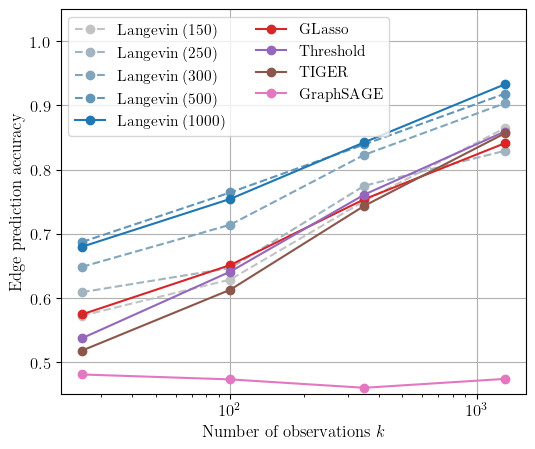

In [10]:
filename = "outputs/results_ergm_different_dataset_sizes.csv"
tuneable_methods = ['langevin_posterior_150', 'langevin_posterior_250', 'langevin_posterior_300',
                    'langevin_posterior_500', 'langevin_posterior_1000', 'threshold', 
                    'gnn'
                    ]
fixed_methods = ["glasso", "tiger"]
train_size = 0.5
threshold_grid = {
    "langevin_posterior_150": np.linspace(0.45, 0.95, 5),
    "langevin_posterior_250": np.linspace(0.45, 0.95, 5),
    "langevin_posterior_300": np.linspace(0.45, 0.95, 5),
    "langevin_posterior_500": np.linspace(0.45, 0.95, 5),
    "langevin_posterior_1000": np.linspace(0.45, 0.95, 5),
    "threshold": np.logspace(-1, 0, 5),
    "gnn": np.linspace(0.2, 0.8, 5),
}
metric = "accuracy"
col_x_axis = "num_obs"

np.random.seed(0)

scores = compute_estimation_performance(filename, tuneable_methods, fixed_methods, train_size, threshold_grid, metric, col_x_axis, n_splits=10)

num_samples_models = [150, 250, 300, 500, 1000]

def color_fader(c1, c2, mix=0):
    c1 = np.array(mpl.colors.to_rgb(c1))
    c2 = np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1 - mix) * c1 + mix * c2)

labels = {f"langevin_posterior_{num_samples}": f"Langevin ({num_samples})" for num_samples in num_samples_models}
labels.update({
    "glasso": "GLasso",
    "threshold": "Threshold",
    "tiger": "TIGER",
    "gnn": "GraphSAGE",
})

colors = {
    "langevin_posterior_1000": '#1f77b4',
    **{f"langevin_posterior_{num_samples}": color_fader('#c3c3c3', '#1f77b4', mix=i/(len(num_samples_models))) for i, num_samples in enumerate(num_samples_models[:-1])},
    "glasso": "#d62728",
    "threshold": "#9467bd",
    "tiger": "#8c564b",
    "gnn": "#e377c2",
}

linestyles = {
    "langevin_posterior_1000": '-',
    **{f"langevin_posterior_{num_samples}": '--' for num_samples in num_samples_models[:-1]},
    "glasso": "-",
    "clime": '-',
    "threshold": "-",
    "tiger": "-",
    "gnn": "-",
}
plot_results(scores, labels, title="", colors=colors, linestyles=linestyles,
             legend_loc="upper left", ylims=(0.45, 1.05), legend_ncol=2, output_file="outputs/plots/ergm_different_dataset_sizes.pdf")